# Mega Yolo -- train the model

## Some toggles for if you want to re-start from weights

In [74]:
# Do you want to re-run from an already generated train/valid/test split?
#  -- this is useful for feature testing and/or re-starting from weights
re_run_from_splits = True

# if restarting, how many previous log files do we want to look at?
nRecent = 7 # for the 1st restart, this will be 1, for the 2nd, 2, etc

# set to true if you are not re-running from the same dataset
regenAnchors = False
 
# use a saved weights file? Set to None if not and training will start anew
#saved_weights_file = 'weights/savedWeights/training_1_model_l0.017813377.h5'
saved_weights_file = None

#fileStorage = 'binaries/' # binaries is where things are -- MAIN   
#extraName = '' # append to training weights name

# for feature collections
#fileStorage = 'binaries_model1/' # binaries is where things are -- MAIN   
#extraName = 'model1' # never use 8, this is our usual model?

#fileStorage = 'binaries_model1_inverted/' # binaries is where things are -- MAIN   
#extraName = 'model1_inverted'

#fileStorage = 'binaries_model1_inverted_palletized/'
#extraName = 'model1_inverted_palletized'

# fileStorage = 'binaries_model2/'
# extraName = 'model2'

#fileStorage = 'binaries_model3/'
#extraName = 'model3'

#fileStorage = 'binaries_model4/'
#extraName = 'model4'

#fileStorage = 'binaries_model5/'
#extraName = 'model5'

#fileStorage = 'binaries_model5_maxTag125/'
#extraName = 'model5_maxTag125'

# fileStorage = 'binaries_model6/'
# extraName = 'model6'

# fileStorage = 'binaries_model8/'
# extraName = 'model8'

fileStorage = 'binaries_model8/'; method='npz'
#fileStorage = 'binaries_model8_pickle/'; method='pickle'
#fileStorage = 'binaries_model8_noncom/'; method = 'npy'
#fileStorage = 'binaries_model8_noncomz/'; method = 'npz'

extraName = 'model8'

In [75]:
# toggle for if on google collab or not
import os

In [76]:
from sys import path
path.append('../')
import config
classDirMain = config.save_binary_dir #+ fileStorage
# where are raw images?
images_pulled_dir = config.images_jpeg_dir #'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/' ## what about Dropbox though????
classDirMainHOME = fileStorage 
splitsDir = config.tmp_storage_dir

In [77]:
# # some parameters for different architectures of YOLO
batch_size = 10
num_epochs = 125 #150 #300

#IMAGE_H, IMAGE_W = 512, 512
image_size = config.IMAGE_H # assume width=height

TRAIN_BATCH_SIZE = batch_size #10
VAL_BATCH_SIZE   = batch_size #10

In [78]:
# where annotations and features files
#classDir_main_to = classDirMain + 'yolo_512x512_cap_ann/'
#classDir_main_to_imgs = classDirMain + 'binaries/'#+ 'yolo_512x512/'
classDir_main_to = classDirMain + config.ann_name + str(int(config.IMAGE_H)) + 'x' + str(int(config.IMAGE_W))  + '_ann/'

classDir_main_to_imgs = classDirMain + fileStorage.split('/')[-2] + '/'
classDir_main_to, classDir_main_to_imgs

('/Users/jillnaiman/MegaYolo/yolo_512x512_ann/',
 '/Users/jillnaiman/MegaYolo/binaries_model8/')

In [79]:
#!conda install numba --yes
#logsDir

In [80]:
import os
import glob
import re
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.cElementTree as ET

# make more better?
#from numba import jit
from time import perf_counter
import sys

# for v5
import math
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers

In [81]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import tensorflow.keras.backend as K
import imgaug as ia
from imgaug import augmenters as iaa

# my imports
import pickle
#from classification_utils import make_get_csv
import pandas as pd
from PIL import Image
import json
#from classification_utils import train_test_valid_split
from scipy import stats
import shutil

# for restart
from tensorflow.python.summary.summary_iterator import summary_iterator
import struct
from datetime import date as DATE

# get parse
from mega_yolo_utils import build_model, train_test_valid_split, \
    process_box, process_layer, box_iou, compute_nms, iou, num_cluster, generator, \
    get_n_features
from general_utils import parse_annotation

Tensorflow version : 2.4.1
GPU : []


## First, data setup

 * Define classes
 * Grab image location info, grab boxes
 * Remap images to new size for running through YOLO
 * get 9 anchors -- why 9? because that is the code we are grabbing, that is why :P

In [82]:
# Grab labels
annotations = glob.glob(classDir_main_to + '*')
len(annotations)

5515

Parse annotations -- **NOTE: this can take a while!**

In [83]:
##### what about anchors -- do we want to regenerate? Generally keep this as True...
#####regenAnchors = True
# ... unless we are re-running from a previous split
if re_run_from_splits: regenAnchors = False
#if regenAnchorsAnyway: regenAnchors = True

if regenAnchors:
    bboxes = []
    

# this parsing does some loading on collab that I'm not 100% sure about, but seems necessary
#   to load into memory, so keep it and figure it out later
def load_parse_data_split(X_full):
    Y_full_str = np.array([]) # have to loop and give best guesses for the pages that have multiple images/classes in them
    slabels = np.array([])
    for ii, X in enumerate(X_full):
        if ii%200 == 0: print('on ', ii, ' of ', len(X_full))
        tree = ET.parse(X)
        tags = np.array([])
        for elem in tree.iter(): 
            if 'object' in elem.tag or 'part' in elem.tag:                  
                box = np.zeros((5))
                for attr in list(elem):
                    if 'name' in attr.tag:
                        if attr.text is not None:
                            tags = np.append(tags,attr.text)
                            slabels = np.append(slabels,attr.text)
                        #print(tags, slabels)
                    if regenAnchors:
                        if 'bndbox' in attr.tag and 'bndboxOrig' not in attr.tag:
                            for dim in list(attr):
                                if 'xmin' in dim.tag:
                                    box[0] = int(round(float(dim.text)))
                                if 'ymin' in dim.tag:
                                    box[1] = int(round(float(dim.text)))
                                if 'xmax' in dim.tag:
                                    box[2] = int(round(float(dim.text)))
                                if 'ymax' in dim.tag:
                                    box[3] = int(round(float(dim.text)))
                if regenAnchors and len(box)>0: bboxes.append(np.asarray(box))
        if len(tags) > 0:
            #print(tags)
            modeClass = stats.mode(tags).mode[0] # most frequent class that pops up on this page
            Y_full_str = np.append(Y_full_str, modeClass) # class in string
        else:
            Y_full_str = np.append(Y_full_str, 'none')
    return Y_full_str,slabels

# NEXT: do a quick test run-through of the data generator for train/test splits
X_full = np.array(annotations)

start_time = perf_counter( )
Y_full_str,slabels = load_parse_data_split(X_full)
stop_time = perf_counter( )
print('    Elapsed wall clock time = %g seconds.' % (stop_time - start_time) )
    
# also do regeneration of anchors
if regenAnchors: bboxes = np.array(bboxes)

on  0  of  5515
on  200  of  5515
on  400  of  5515
on  600  of  5515
on  800  of  5515
on  1000  of  5515
on  1200  of  5515
on  1400  of  5515
on  1600  of  5515
on  1800  of  5515
on  2000  of  5515
on  2200  of  5515
on  2400  of  5515
on  2600  of  5515
on  2800  of  5515
on  3000  of  5515
on  3200  of  5515
on  3400  of  5515
on  3600  of  5515
on  3800  of  5515
on  4000  of  5515
on  4200  of  5515
on  4400  of  5515
on  4600  of  5515
on  4800  of  5515
on  5000  of  5515
on  5200  of  5515
on  5400  of  5515
    Elapsed wall clock time = 4.31602 seconds.


Get anchors, if that is what you wanna do:

In [84]:
# assume location of saved anchors:
saveFileAnchors = classDirMain + 'weights/anchors.pickle'
# hack for local debugging
#if '/Users/jillnaiman' in thisDir:
saveFileAnchors = splitsDir + 'anchors.pickle'

if regenAnchors:
    boxes = []
    for b in bboxes:
        boxes.append([b[2]-b[0], b[3]-b[1]])
    boxes = np.array(boxes)
    
    anchors = generator(boxes,k=num_cluster)
    print('NEW ANCHORS:')
    
    # save!
    with open(saveFileAnchors, 'wb') as ff:
        pickle.dump(anchors, ff)
else:
    print('from saved:')
    with open(saveFileAnchors, 'rb') as f:
        anchors = pickle.load(f)    
    
print(anchors)

from saved:
[[195.  21.]
 [203.   7.]
 [ 51.   5.]
 [313. 199.]
 [359. 391.]
 [435.  16.]
 [399. 307.]
 [204. 114.]
 [ 15. 355.]]


In [85]:
LABELS = np.unique(slabels).tolist()
CLASS = len(LABELS)
##if use_only_one_class: CLASS = 1
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [86]:
# strings to integers
labels = np.arange(0,len(LABELS))

In [87]:
labels, LABELS

(array([0, 1, 2, 3]), ['figure', 'figure caption', 'math formula', 'table'])

Create splits one way or the other.  Using the function makes sure the classes are evenly split as there can be un-even classes (for example, there might be way more figures/figure captions than tables).  Note: each instance is tagged as having one class but this is just the most frequent type on that page -- pages can sometimes have multiple types.

Or, load from previous file.

In [88]:
# # splits
# X_train = np.loadtxt(splitsDir + 'train.csv', dtype=str, delimiter=',')
# X_test = np.loadtxt(splitsDir + 'test.csv', dtype=str, delimiter=',')
# X_valid = np.loadtxt(splitsDir + 'valid.csv', dtype=str, delimiter=',')

In [89]:
#X_train

In [90]:
from mega_yolo_utils import augmentation_generator, csv_gen
onGoogle=False
import time

In [91]:
import general_utils
from importlib import reload
reload(general_utils)
from general_utils import parse_annotation

In [92]:
splitsDirIn = None
if onGoogle: splitsDirIn = classDirMain
train_gen_csv = csv_gen('train', splitsDir=splitsDirIn)
valid_gen_csv = csv_gen('valid',splitsDir=splitsDirIn)
test_gen_csv = csv_gen('test',splitsDir=splitsDirIn)

class ArtificialDatasetNonAug(tf.data.Dataset):

    #@tf.function
    def _dataset_gen(split, batch_size, method='npz'):
        while True:
            true_boxes = []; imgs = []; files = []
            #time1 = time.perf_counter()

            while len(files) < batch_size:
                if type(split) == str:
                    if b'train' in bytes(split, encoding='utf8'): # NOTE, must be bytes here!!!
                        line = next(train_gen_csv)
                    elif b'valid' in bytes(split, encoding='utf8'):
                        line = next(valid_gen_csv)
                    elif b'test' in bytes(split, encoding='utf8'):
                        line = next(test_gen_csv)
                else:
                    if b'train' in split: # NOTE, must be bytes here!!!
                        line = next(train_gen_csv)
                    elif b'valid' in split:
                        line = next(valid_gen_csv)
                    elif b'test' in split:
                        line = next(test_gen_csv)

                files.append(line.strip())

            # parse and get full names
            #time2 = time.perf_counter()
            #print('parse CSV:', time2-time1)
            try:
                imgs_name, bbox = parse_annotation(files, LABELS, 
                                                   feature_dir=classDir_main_to_imgs,
                                                   annotation_dir=classDir_main_to)
            except:
                print('error parsing:', imgs_name)
                
            #print('method is ', method)
            if method == bytes('npz', encoding='utf8'): ender = '.npz'
            if method == bytes('npy', encoding='utf8'): ender = '.npy'
            if method == bytes('pickle', encoding='utf8'): ender = '.pickle'
            #print(imgs_name)
            # do a debug check
            for im in imgs_name:
                #print(im)
                if ender not in im:
                    print('no np file, no pickle file, no npy file')
                    import sys; sys.exit()
                    
            #time3 = time.perf_counter()
            #print('Parse annotation:',time3-time2)

            # read in and keep images -- npy files/npz
            if method == bytes('npz', encoding='utf8'):
                for im in imgs_name:
                    with np.load(im) as b:
                        #b = b['arr_0']/255.0
                        imgs.append(b['arr_0']/255.0)
            elif method == bytes('npy', encoding='utf8'):
                for im in imgs_name:
                    b=np.load(im)
                    if type(b) != np.ndarray:
                        b = b['arr_0'] # WHY????
                    imgs.append(b/255.0)
            elif method == bytes('pickle', encoding='utf8'):
                for im in imgs_name:
                    with open(im, 'rb') as f:
                        b = pickle.load(f) 
                        imgs.append(np.array(b)/255.0)
            else:
                print('no idea what this method is')
                        
                
            #time4 = time.perf_counter()
            #print('Load data:', time4-time3)

            # finally, format for output
            y_true1, y_true2, y_true3 = [],[],[]
            for b in bbox:
                y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
                y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)
            # if there is no box, do something different
            if len(bbox) == 0:
                # fake a box
                b = np.array([[111.,  59., 403., 364. ,  4.]])
                y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
                y1[:] = 0; y2[:]=0;y3[:]=0
                y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)        
            img = tf.cast(np.array(imgs), tf.float32)     
            #time5 = time.perf_counter()
            #print('process blocks:', time5-time4)
            del imgs
            yield img, tf.cast(y_true1, tf.float32), tf.cast(y_true2, tf.float32), tf.cast(y_true3, tf.float32)



    def __new__(cls,batch_size=32,split='valid', method='npz'):
        dataset = tf.data.Dataset.from_generator(cls._dataset_gen, args=[split, batch_size,method],
                                             output_types = (tf.float32, tf.float32, 
                                                             tf.float32, tf.float32))
        return dataset

In [201]:
imgs_name, bbox = parse_annotation([annotations[0]], LABELS, 
                                                   feature_dir=classDir_main_to_imgs,
                                                   annotation_dir=classDir_main_to)

for im in imgs_name:
    arr = np.load(im)['arr_0']
    
#features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))


In [214]:
#bbox, arr
arr.shape
arr.reshape(1,arr.shape[0]*arr.shape[1]*arr.shape[2]).shape
bbox[0].shape

# maxboxes stuff
maxboxes = 20

boxout = np.zeros([maxboxes+1,5])
boxout[:bbox[0].shape[0],:] = bbox[0]

In [277]:
## start here

In [448]:
tf.train.FloatList?

Init signature: tf.train.FloatList(self, /, *args, **kwargs)
Docstring:      A ProtocolMessage
File:           ~/anaconda3/envs/Paper1/lib/python3.7/site-packages/tensorflow/core/example/feature_pb2.py
Type:           GeneratedProtocolMessageType
Subclasses:     


In [445]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# def _float32_feature(value):
#     """Returns an int64_list from a bool / enum / int / uint."""
#     return tf.train.Feature(float_list=tf.train.Float32List(value=[value]))

In [454]:
# Create a dictionary with features that may be relevant.
def image_example(image, boxes):
    #image_shape = tf.io.decode_jpeg(image_string).shape
    image_string = image.astype('float32')/255.0
    image_string = image.reshape(image.shape[0]*image.shape[1]*image.shape[2])
    
    nfeatures = image.shape[2]
    nboxes = boxes.shape[0]
    if nboxes>0:
        boxout = boxes.reshape(boxes.shape[0]*boxes.shape[1])
    else:
        boxout = np.array([])
    
    feature = {
      #'nbox': _int64_feature(np.int64(nboxes)),
      #'nfeatures': _int64_feature(np.int64(nfeatures)),
      'nbox': _float_feature(np.float32(nboxes)),
      'nfeatures': _float_feature(np.float32(nfeatures)),
      'boxes': _bytes_feature(boxout.astype('float32').tobytes()),
      'image_raw': _bytes_feature(image_string.astype('float32').tobytes()),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

How many TFRecord files to have? So that each are $\sim$100Mb: https://docs.w3cub.com/tensorflow~guide/performance/performance_guide

In [298]:
filelist = pd.read_csv(config.tmp_storage_dir+'train.csv',names=['filename'])['filename'].values
filelist

array(['/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1952ApJ___115___82K_p1.xml',
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1994ApJ___427L__43F_p4.xml',
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1995ApJ___445__246C_p6.xml',
       ...,
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1978ApJ___220___14H_p1.xml',
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1982ApJ___252__269Y_p2.xml',
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1982ApJ___258__467Y_p2.xml'],
      dtype=object)

In [302]:
classDir_main_to_imgs, classDir_main_to

('/Users/jillnaiman/MegaYolo/binaries_model8/',
 '/Users/jillnaiman/MegaYolo/yolo_512x512_ann/')

In [310]:
np.random.random?

Docstring:
random(size=None)

Return random floats in the half-open interval [0.0, 1.0). Alias for
`random_sample` to ease forward-porting to the new random API.
Type:      builtin_function_or_method


In [312]:
np.random.random([maxboxes,5]).shape

(20, 5)

In [450]:
# write one image file and see how big it is
record_file = config.tmp_storage_dir+'test.tfrecords'
# what is our max boxes
maxboxes = -1
for a in filelist:
    a = classDir_main_to + a.split('/')[-1]
    try:
        imgs_name, bbox = parse_annotation([a], LABELS,
                                           feature_dir=classDir_main_to_imgs,
                                           annotation_dir=classDir_main_to) 
    except:
        print('no file', a)
    if len(bbox) > 0:
        maxboxes = max([maxboxes,len(bbox[0])])
    
# print with maxboxes
with tf.io.TFRecordWriter(record_file) as writer:
    
    a = classDir_main_to + filelist[0].split('/')[-1]
    imgs_name, bbox = parse_annotation([a], LABELS,
                                           feature_dir=classDir_main_to_imgs,
                                           annotation_dir=classDir_main_to) 
    # fake boxes
    fakebox = np.random.random([maxboxes,5])
    tf_example = image_example(arr,fakebox)
    writer.write(tf_example.SerializeToString())

no file /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1992AJ____103_1151C_p9.xml
no file /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1991ApJS___76__455E_p6.xml
no file /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1990ApJ___365__510C_p2.xml
no file /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1996ApJ___467__887H_p4.xml
no file /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1994ApJS___95__457W_p15.xml


In [451]:
filesize = os.path.getsize(record_file)
filesize, filesize/(100.*1e6)

(12583424, 0.12583424)

In [452]:
#i.e we want:
nfiles_per_file = 100*1e6//filesize
nfiles_per_file # per recordio

7.0

In [453]:
nfiles = int(np.ceil(len(filelist)*1.0/nfiles_per_file))
nfiles

592

In [354]:
# write some training

itrain = 0
#iloop = 0
#record_file = '/Users/jillnaiman/Downloads/tmp/rio/train'
record_file = '/Users/jillnaiman/Downloads/tmp/rio/train_{}.tfrecords'

itotalLoop = 0
for index in range(nfiles):
    if index%50 == 0: print('on', index,'of',nfiles)
    with tf.io.TFRecordWriter(record_file.format(index)) as writer:
        #print(index*int(nfiles_per_file),min([(index+1)*int(nfiles_per_file),len(filelist)]))
        for iloop,a in enumerate(filelist[index*int(nfiles_per_file):min([(index+1)*int(nfiles_per_file),len(filelist)])]):
            #print(iloop,a)
            a = classDir_main_to + a.split('/')[-1]
            
            try:
                imgs_name, bbox = parse_annotation([a], LABELS,
                                                   feature_dir=classDir_main_to_imgs,
                                                   annotation_dir=classDir_main_to)
            except:
                print('cant find', a, ', moving on...')
                continue
            arr = np.load(imgs_name[0])['arr_0']

            if len(bbox) > 0: 
                bbox = np.array(bbox[0])
            else:
                bbox = np.array([])
            tf_example = image_example(arr,bbox)
            writer.write(tf_example.SerializeToString())

            # if itotalLoop%int(nfiles_per_file)==0: 
            #     print(index,iloop,itrain)
            #     itrain+=1
            # itotalLoop += 1

    #if index == 2: import sys; sys.exit()



on 0 of 592
on 50 of 592
on 100 of 592
on 150 of 592
cant find /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1992AJ____103_1151C_p9.xml , moving on...
on 200 of 592
on 250 of 592
cant find /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1991ApJS___76__455E_p6.xml , moving on...
cant find /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1990ApJ___365__510C_p2.xml , moving on...
on 300 of 592
on 350 of 592
cant find /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1996ApJ___467__887H_p4.xml , moving on...
on 400 of 592
cant find /Users/jillnaiman/MegaYolo/yolo_512x512_ann/1994ApJS___95__457W_p15.xml , moving on...
on 450 of 592
on 500 of 592
on 550 of 592


In [355]:
list_of_records = glob.glob('/Users/jillnaiman/Downloads/tmp/rio/train_*.tfrecords')
#list_of_records

In [356]:
raw_image_dataset = tf.data.TFRecordDataset(list_of_records)

In [360]:
# Create a dictionary describing the features.
image_feature_description = {
    'nbox': tf.io.FixedLenFeature([], tf.int64),
    'nfeatures': tf.io.FixedLenFeature([], tf.int64),
    'boxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}


In [397]:
anchors

array([[195.,  21.],
       [203.,   7.],
       [ 51.,   5.],
       [313., 199.],
       [359., 391.],
       [435.,  16.],
       [399., 307.],
       [204., 114.],
       [ 15., 355.]])

In [426]:
#image_size

In [589]:
#@tf.function
def process_box2(boxes, labels,anchors,CLASS,image_size=config.IMAGE_H):
    '''
    labels: integer numbers associated with labels, JPN: does this start at 0 or 1??
    boxes: [number of boxes on page, xmin, ymin, xmax, ymax]
    returns: the correctly formatted 3 y-trues
    '''
    anchors_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    #anchors = anchors
    box_centers = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
    box_size = boxes[:, 2:4] - boxes[:, 0:2]
    #print(box_size)
    
    # y_true_1 = tf.zeros((tf.math.floordiv(image_size,32),
    #                         tf.math.floordiv(image_size,32),
    #                         3, 5 + CLASS), tf.float32)
    # y_true_2 = tf.zeros((tf.math.floordiv(image_size,16),
    #                         tf.math.floordiv(image_size,16),
    #                         3, 5 + CLASS), tf.float32)
    # y_true_3 = tf.zeros((tf.math.floordiv(image_size,8),
    #                         tf.math.floordiv(image_size,8),
    #                         3, 5 + CLASS), tf.float32)
    #print('hi')

    y_true_1 = np.zeros((image_size // 32,
                            image_size // 32,
                            3, 5 + CLASS.numpy()), np.float32)
    y_true_2 = np.zeros((image_size // 16,
                            image_size // 16,
                            3, 5 + CLASS.numpy()), np.float32)
    y_true_3 = np.zeros((image_size // 8,
                            image_size // 8,
                            3, 5 + CLASS.numpy()), np.float32)
    # y_true_1 = np.zeros((tf.math.floordiv(image_size,32),
    #                         tf.math.floordiv(image_size,32),
    #                         3, 5 + CLASS.numpy()), np.float32)
    # y_true_2 = np.zeros((tf.math.floordiv(image_size,16),
    #                         tf.math.floordiv(image_size,16),
    #                         3, 5 + CLASS), np.float32)
    # y_true_3 = np.zeros((tf.math.floordiv(image_size,8),
    #                         tf.math.floordiv(image_size,8),
    #                         3, 5 + CLASS), np.float32)
    y_true = [y_true_1, y_true_2, y_true_3]

    box_size = tf.expand_dims(box_size, 1)

    min_np = tf.maximum(- box_size / 2, - anchors / 2)
    max_np = tf.minimum(box_size / 2, anchors / 2)

    whs = max_np - min_np

    overlap = whs[:, :, 0] * whs[:, :, 1]
    union = box_size[:, :, 0] * box_size[:, :, 1] + anchors[:, 0] * anchors[:, 1] - whs[:, :, 0] * whs[:, :, 1] + 1e-10

    iou = overlap / union
    best_match_idx = tf.argmax(iou, axis=1)

    #ratio_dict = {1.: 8., 2.: 16., 3.: 32.}
    ratio_dict = tf.constant([8,16,32],tf.int32)
    #ratio = -1
    #for i, idx in enumerate(best_match_idx):
    for i in tf.range(tf.shape(best_match_idx)[0]):
        idx = best_match_idx[i]
        feature_map_group = 2 - idx // 3
        ind = tf.cast(tf.math.ceil((tf.cast(idx + 1,tf.float32)) / 3.),tf.int32)
        #ratio = ratio_dict[np.ceil((idx + 1) / 3.)]
        ratio = tf.slice(ratio_dict,[ind],[1])
        x = int(tf.math.floor(box_centers[i, 0] / tf.cast(ratio,tf.float32)))
        y = int(tf.math.floor(box_centers[i, 1] / tf.cast(ratio,tf.float32)))
        #k = anchors_mask[feature_map_group].index(idx)
        m1 = tf.gather(anchors_mask,feature_map_group)
        k = tf.gather(m1,idx)
        #k = tf.gather(anchors_mask[feature_map_group],idx)
        c = labels[i]

        y_true[feature_map_group][y, x, k, :2] = box_centers[i]
        # y_true = y_true[feature_map_group][y, x, k, :2].assign(box_centers[i])
        y_true[feature_map_group][y, x, k, 2:4] = box_size[i]
        y_true[feature_map_group][y, x, k, 4] = 1.
        # if feature_map_group == 0:
        #     yt2 = np
        #     y_true_11[y,x,k,:2] = box_centers[i]
        try:
            #y_true[feature_map_group][y, x, k, 5 + c] = 1.
            y_true[feature_map_group][y, x, k, 5 + c -1] = 1. # labels start at 0
        except:
            print('in parse')
            print(y,x,k,c, 5+c)
            print(labels)

    return y_true_1, y_true_2, y_true_3

In [658]:
#@tf.function
def process_box3(boxes, labels,anchors,CLASS):
    '''
    labels: integer numbers associated with labels, JPN: does this start at 0 or 1??
    boxes: [number of boxes on page, xmin, ymin, xmax, ymax]
    returns: the correctly formatted 3 y-trues
    '''
    anchors_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    #anchors = anchors
    box_centers = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
    box_size = boxes[:, 2:4] - boxes[:, 0:2]

    y_true_1 = np.zeros((image_size // 32,
                            image_size // 32,
                            3, 5 + CLASS), np.float32)
    y_true_2 = np.zeros((image_size // 16,
                            image_size // 16,
                            3, 5 + CLASS), np.float32)
    y_true_3 = np.zeros((image_size // 8,
                            image_size // 8,
                            3, 5 + CLASS), np.float32)

    y_true = [y_true_1, y_true_2, y_true_3]

    box_size = np.expand_dims(box_size, 1)

    min_np = np.maximum(- box_size / 2, - anchors / 2)
    max_np = np.minimum(box_size / 2, anchors / 2)

    whs = max_np - min_np

    overlap = whs[:, :, 0] * whs[:, :, 1]
    union = box_size[:, :, 0] * box_size[:, :, 1] + anchors[:, 0] * anchors[:, 1] - whs[:, :, 0] * whs[:, :, 1] + 1e-10

    iou = overlap / union
    best_match_idx = np.argmax(iou, axis=1)

    ratio_dict = {1.: 8., 2.: 16., 3.: 32.}
    for i, idx in enumerate(best_match_idx):
        feature_map_group = 2 - idx // 3
        ratio = ratio_dict[np.ceil((idx + 1) / 3.)]
        x = int(np.floor(box_centers[i, 0] / ratio))
        y = int(np.floor(box_centers[i, 1] / ratio))
        k = anchors_mask[feature_map_group].index(idx)
        c = labels[i].numpy()

        y_true[feature_map_group][y, x, k, :2] = box_centers[i]
        y_true[feature_map_group][y, x, k, 2:4] = box_size[i]
        y_true[feature_map_group][y, x, k, 4] = 1.
        try:
            y_true[feature_map_group][y, x, k, 5 + c -1] = 1. # labels start at 0
        except:
            print('in parse')
            print('y','x','k','c')
            print(y,x,k,c, 5+c)
            print(labels)

    return y_true_1, y_true_2, y_true_3

In [665]:
labels

array([0, 1, 2, 3])

In [659]:
def _parse_image_function(example_proto,anchors,CLASS):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)

    nboxes = image_features['nbox']
    nfeatures = image_features['nfeatures']
    boxes = tf.io.decode_raw(image_features['boxes'],tf.float32)
    boxes = tf.reshape(boxes,[nboxes,5])
    images_raw = image_features['image_raw']
    image = tf.io.decode_raw(images_raw,tf.float32)
    image = tf.reshape(image,[config.IMAGE_H,config.IMAGE_W,nfeatures])

    # process boxes
    y1,y2,y3 = tf.py_function(process_box3,
                              (boxes[:,:4], boxes[:,4],anchors,CLASS),
                              (tf.float32,tf.float32,tf.float32))   
    #y1,y2,y3 = process_box3(boxes[:,:4], boxes[:,4],anchors,CLASS)
    
    return image, nboxes, nfeatures, boxes,y1,y2,y3
    
    #return tf.io.parse_single_example(example_proto, image_feature_description)


In [664]:
#parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
anchors_in = tf.constant(anchors,tf.float32)
CLASS_in = tf.constant(CLASS,tf.int32)
parsed_image_dataset = raw_image_dataset.map(lambda example_proto:_parse_image_function(example_proto,anchors,CLASS))
parsed_image_dataset

TypeError: in user code:

    /var/folders/t5/9xgccmv92hnfvjwd62mk8zqh0000gn/T/ipykernel_25922/799275935.py:4 None  *
        lambda example_proto:_parse_image_function(example_proto,LABELS,anchors,CLASS))

    TypeError: tf___parse_image_function() takes 3 positional arguments but 4 were given


In [661]:
#boxes

In [662]:
#for checking:
import IPython.display as display

in parse
y x k c
24 15 0 4.0 9.0
tf.Tensor([4. 4. 4.], shape=(3,), dtype=float32)
in parse
y x k c
2 7 1 4.0 9.0
tf.Tensor([4. 4. 4.], shape=(3,), dtype=float32)
in parse
y x k c
6 7 1 4.0 9.0
tf.Tensor([4. 4. 4.], shape=(3,), dtype=float32)


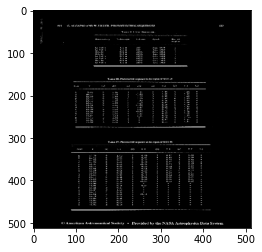

In [663]:
for image,nboxes,nfeatures,boxes,y1,y2,y3 in parsed_image_dataset.take(1):
    # nboxes = image_features['nbox']
    # nfeatures = image_features['nfeatures']
    # boxes = tf.io.decode_raw(image_features['boxes'],tf.float32)
    # boxes = tf.reshape(boxes,[nboxes,5])
    # images_raw = image_features['image_raw']
    # image = tf.io.decode_raw(images_raw,tf.float32)
    # image = tf.reshape(image,[config.IMAGE_H,config.IMAGE_W,nfeatures])
    imgPlot = image.numpy()
    plt.imshow(imgPlot[:,:,0],cmap='gray')
    #print(nboxes,nfeatures,boxes)

In [395]:
# for image_features in parsed_image_dataset.take(1):
#     nboxes = image_features['nbox']
#     nfeatures = image_features['nfeatures']
#     boxes = tf.io.decode_raw(image_features['boxes'],tf.float32)
#     boxes = tf.reshape(boxes,[nboxes,5])
#     images_raw = image_features['image_raw']
#     image = tf.io.decode_raw(images_raw,tf.float32)
#     image = tf.reshape(image,[config.IMAGE_H,config.IMAGE_W,nfeatures])
#     imgPlot = image.numpy()
#     plt.imshow(imgPlot[:,:,0],cmap='gray')
#     print(nboxes,nfeatures,boxes)

In [396]:
#imgPlot[:,:,0]

In [ ]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [338]:
def serialize_example(nbox,nfeatures,boxes,image_raw):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible
    # data type.
    feature = {
      'nbox': _int64_feature(nbox),
      'nfeatures': _int64_feature(nfeatures),
      'boxes': _bytes_feature(boxes),
      'image_raw': _bytes_feature(image_raw),
    }

    # Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [322]:
# to read
def parse_proto(example_proto):
  features = {
    'X': tf.FixedLenFeature((345,), tf.float32),
    'y': tf.FixedLenFeature((5,), tf.float32),
  }
  parsed_features = tf.parse_single_example(example_proto, features)
  return parsed_features['X'], parsed_features['y']

def read_tfrecords(file_names=("file1.tfrecord", "file2.tfrecord", "file3.tfrecord"),
                   buffer_size=10000,
                   batch_size=100):
    dataset = tf.contrib.data.TFRecordDataset(file_names)
    dataset = dataset.map(parse_proto)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return tf.contrib.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)

bytes_list {
  value: ""
}

In [339]:
example_proto = tf.train.Example.FromString(serialized_example)

NameError: name 'serialized_example' is not defined

In [248]:
bbox[0].reshape(1*5).shape

(5,)

In [213]:
bbox[0].shape

(1, 5)

In [209]:
features_dataset = tf.data.Dataset.from_tensor_slices((arr.reshape(1,arr.shape[0]*arr.shape[1]*arr.shape[2]),
                                                       bbox[0]))


In [210]:
features_dataset

<TensorSliceDataset shapes: ((3145728,), (5,)), types: (tf.uint8, tf.float64)>

In [211]:
for f0,f1 in features_dataset.take(1):
    print(f0)
    print(f1)

tf.Tensor([0 0 0 ... 0 0 0], shape=(3145728,), dtype=uint8)
tf.Tensor([ 46. 451. 257. 473.   2.], shape=(5,), dtype=float64)


In [220]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [221]:
def serialize_example(feature0, feature1):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible
    # data type.
    feature = {
      'feature0': _float_feature(feature0),
      'feature1': _float_feature(feature1),
    }

    # Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [222]:
def tf_serialize_example(f0,f1):
    tf_string = tf.py_function(
        serialize_example,
        (f0, f1),  # Pass these args to the above function.
        tf.string)      # The return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar.

In [241]:
#tf.cast(f0,tf.float32)
features_dataset
for f0,f1 in features_dataset.take(1):
    print(f0,f1)

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3145728,), dtype=float64) tf.Tensor(
[ 46. 451. 257. 473.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.], shape=(105,), dtype=float64)


In [244]:
#tf_serialize_example(f0,f1)

serialize_example(f0np,f1np)

TypeError: array([[0., 0., 0., ..., 0., 0., 0.]]) has type numpy.ndarray, but expected one of: int, long, float

In [245]:

# for each annotation
boxout = np.zeros([maxboxes+1,5])
boxout[:bbox[0].shape[0],:] = bbox[0]

f0np = arr.reshape(arr.shape[0]*arr.shape[1]*arr.shape[2])
f0np = f0np.astype('float')/255.
f1np = boxout.reshape(boxout.shape[0]*boxout.shape[1])

features_dataset = tf.data.Dataset.from_tensor_slices((f0np,f1np))

for f0,f1 in features_dataset.take(1):
    #print(f0)
    #print(f1)
    tf_serialize_example(f0,f1)


ValueError: Dimensions 3145728 and 105 are not compatible

In [238]:
f0,f1

(<TensorSliceDataset shapes: (3145728,), types: tf.float64>,
 <TensorSliceDataset shapes: (105,), types: tf.float64>)

In [236]:
f1

<TensorSliceDataset shapes: (21, 5), types: tf.float64>

In [93]:
# # load 1
# imgs_name, bbox = parse_annotation([annotations[0]], LABELS, 
#                                                    feature_dir=classDir_main_to_imgs,
#                                                    annotation_dir=classDir_main_to)


# # read in and keep images -- npy files
# for im in imgs_name:
#     arr = np.load(im)#['arr_0']

In [94]:
#np.load(im)

In [95]:
#arr.astype('uint8')

In [96]:
#nbatch = 10

In [97]:
# #dataset = ArtificialDatasetNonAug(batch_size=32,split='valid')
# b = np.load('/Users/jillnaiman/MegaYolo/binaries_model8_noncom/1988ApJ___334__144K_p8.npy')
# b

In [98]:
#b['arr_0']

In [99]:
# benchmark tests
import time
def benchmark(dataset, num_epochs=1, nbatch=32):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        ienum=0
        for sample in dataset:
            #if ienum%10==0: print(ienum)
            #print(ienum)
            # Performing a training step
            time.sleep(0.01)
            ienum+=1
            if ienum>nbatch: break
    print("Execution time:", time.perf_counter() - start_time)

In [100]:
# simple
#benchmark(ArtificialDatasetNonAug(batch_size=10,split='valid'),nbatch=nbatch)


In [ ]:
# try different methods and time
#nbatch = 10; nloop = 10
nbatch = 25; nloop = 4
th = []

for n in range(nloop):
    t1 = time.perf_counter()
    benchmark(ArtificialDatasetNonAug(batch_size=nbatch,split='valid',method=method),
              nbatch=nbatch)
    t2 = time.perf_counter()
    th.append(t2-t1)

In [29]:
np.median(th), np.std(th)

(40.807152897499996, 0.9870036160257788)

In [30]:
classDir_main_to_imgs

'/Users/jillnaiman/MegaYolo/binaries_model8_pickle/'

In [197]:
# for tfrecords files
def parse_proto(example_proto):
    features = {
        'X': tf.io.FixedLenFeature([], tf.float32),
        'x1': tf.io.FixedLenSequenceFeature([10], tf.float32,allow_missing = True,default_value=0),
        'x2': tf.io.FixedLenSequenceFeature([10], tf.float32,allow_missing = True,default_value=0),
        'y1': tf.io.FixedLenSequenceFeature([10], tf.float32,allow_missing = True,default_value=0),
        'y2': tf.io.FixedLenSequenceFeature([10], tf.float32,allow_missing = True,default_value=0),
        'class': tf.io.FixedLenSequenceFeature([10], tf.float32,allow_missing = True,default_value=0),
    }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    print(parsed_features)
    return parsed_features['X']
#     y_true1, y_true2, y_true3 = [],[],[]
#     for b in bbox:
#         y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
#         y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)
#     # if there is no box, do something different
#     if len(bbox) == 0:
#         # fake a box
#         b = np.array([[111.,  59., 403., 364. ,  4.]])
#         y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
#         y1[:] = 0; y2[:]=0;y3[:]=0
#         y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)        
#     img = tf.cast(np.array(imgs), tf.float32)     
#     #time5 = time.perf_counter()
#     #print('process blocks:', time5-time4)
#     del imgs
#     yield img, tf.cast(y_true1, tf.float32), tf.cast(y_true2, tf.float32), tf.cast(y_true3, tf.float32)

    
#     return parsed_features['X'], parsed_features['y']

def read_tfrecords(file_names=("file1.tfrecord", "file2.tfrecord", "file3.tfrecord"),
                   buffer_size=10000,
                   batch_size=100):
    dataset = tf.data.TFRecordDataset(file_names)
    dataset = dataset.map(parse_proto)
    return dataset

In [198]:
dirtf = '/Users/jillnaiman/MegaYolo/binaries_model8_tfrecord/'
tffiles = [dirtf+'1981AJ_____86__206V_p1.tfrecord',
           dirtf+'1992AJ____104_2161O_p5.tfrecord',
           dirtf+'1997AJ____114__913N_p13.tfrecord']


dataset = read_tfrecords(file_names=tffiles)

{'X': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=() dtype=float32>, 'class': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(None, 10) dtype=float32>, 'x1': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(None, 10) dtype=float32>, 'x2': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:3' shape=(None, 10) dtype=float32>, 'y1': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:4' shape=(None, 10) dtype=float32>, 'y2': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:5' shape=(None, 10) dtype=float32>}


In [200]:
for parsed_record in dataset.take(2):
    print(parsed_record)

2021-12-01 18:31:54.646748: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at example_parsing_ops.cc:94 : Invalid argument: Key: x2.  Can't parse serialized Example.


InvalidArgumentError: Key: x2.  Can't parse serialized Example.
	 [[{{node ParseSingleExample/ParseExample/ParseExampleV2}}]]

In [124]:
# now, following: https://stackoverflow.com/questions/48889482/feeding-npy-numpy-files-into-tensorflow-data-pipeline
# try with io decode?
def npy_header_offset(npy_path):
    with open(str(npy_path), 'rb') as f:
        print(f.read(6).decode('utf-8'))
        if f.read(6) != b'\x93NUMPY':
            raise ValueError('Invalid NPY file.')
        version_major, version_minor = f.read(2)
        if version_major == 1:
            header_len_size = 2
        elif version_major == 2:
            header_len_size = 4
        else:
            raise ValueError('Unknown NPY file version {}.{}.'.format(version_major, version_minor))
        header_len = sum(b << (8 * i) for i, b in enumerate(f.read(header_len_size)))
        header = f.read(header_len)
        if not header.endswith(b'\n'):
            raise ValueError('Invalid NPY file.')
        return f.tell()

In [125]:
file_list1 = pd.read_csv(splitsDir+'train.csv',names=['filename'])['filename'].values.astype('str')
file_list = []; nfeatures = -1; dtype = -1
for iff,f in enumerate(file_list1):
    f = f.rstrip('.xml').split('/')[-1]
    if iff==0: # if first one, fill in the gaps
        fg = glob.glob(classDir_main_to_imgs + f + '*')[0]
        mod = fg.split('/')[-1]
        mod = mod[mod.rfind('.')+1:]
        # read in and keep images -- npy files/npz
        if mod == 'npz':
            with np.load(fg) as b:
                nfeatures = b['arr_0'].shape[-1]
                dtype = b['arr_0'].dtype
            header_offset = npy_header_offset(fg)
        elif mod == 'npy':
            b=np.load(fg)
            if type(b) != np.ndarray:
                b = b['arr_0'] # WHY????
                nfeatures = b.shape[-1]
                dtype = b.dtype
        elif mod == 'pickle':
            print('not implemented!')
            import sys; sys.exit()
            with open(fg, 'rb') as ff:
                b = pickle.load(ff) 
                nfeatures = np.array(b).shape[-1]
                dtype = np.array(b).dtype
        else:
            print('no idea what this method is')
        # what is dtype?
        if dtype == np.dtype('uint8'): dtype = tf.uint8
        if dtype == np.dtype('float64'): dtype = tf.float64
    file_list.append(classDir_main_to_imgs+f+'.'+mod)


PK 


ValueError: Invalid NPY file.

In [126]:
# alright maybe try recordio afterall?
#https://github.com/tensorflow/tensorflow/blob/r1.3/tensorflow/examples/how_tos/reading_data/convert_to_records.py
#https://stackoverflow.com/questions/50665144/create-tfrecord-for-object-detection-task
#https://stackoverflow.com/questions/46820500/how-to-handle-large-amouts-of-data-in-tensorflow/47040165#47040165

([], 12, dtype('uint8'))

In [130]:
recordIOdir = config.tmp_storage_dir + 'rio/'

In [162]:
def array_to_tfrecords(X, boxes, output_file):
    if len(boxes)>0:
        x1 = boxes[0][:,0]; y1 = boxes[0][:,1]; x2 = boxes[0][:,2]; y2 = boxes[0][:,3]
        classes = boxes[0][:,4]
    else:
        x1=np.array([]);y1=np.array([]);x2=np.array([]);y2=np.array([]);classes=np.array([])
    # do division already
    X = X/255.
    feature = {
        'X': tf.train.Feature(float_list=tf.train.FloatList(value=X.flatten())),
        'x1': tf.train.Feature(float_list=tf.train.FloatList(value=x1.flatten())),
        'y1': tf.train.Feature(float_list=tf.train.FloatList(value=y1.flatten())),
        'x2': tf.train.Feature(float_list=tf.train.FloatList(value=x2.flatten())),
        'y2': tf.train.Feature(float_list=tf.train.FloatList(value=y2.flatten())),
        'class': tf.train.Feature(float_list=tf.train.FloatList(value=classes.flatten()))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()

    writer = tf.io.TFRecordWriter(output_file)
    writer.write(serialized)
    writer.close()

In [163]:
# imgs_name, bbox = parse_annotation([classDir_main_to+f+'.xml'], LABELS, 
#                                                    feature_dir=classDir_main_to_imgs,
#                                                    annotation_dir=classDir_main_to)

# X = np.load(imgs_name[0])['arr_0']
# array_to_tfrecords(X, bbox, recordIOdir+imgs_name[0].rstrip('.npz').split('/')[-1]+'.tfrecord')

In [171]:
# convert all
for iff,f in enumerate(annotations):
    imgs_name, bbox = parse_annotation([classDir_main_to+f.split('/')[-1]], LABELS, 
                                                       feature_dir=classDir_main_to_imgs,
                                                       annotation_dir=classDir_main_to)

    X = np.load(imgs_name[0])['arr_0']
    array_to_tfrecords(X, bbox, recordIOdir+imgs_name[0].rstrip('.npz').split('/')[-1]+'.tfrecord')
    del X
    
    if iff%100==0: print(iff,'of',len(annotations))

0 of 5515
100 of 5515
200 of 5515
300 of 5515
400 of 5515
500 of 5515
600 of 5515
700 of 5515
800 of 5515
900 of 5515
1000 of 5515
1100 of 5515
1200 of 5515
1300 of 5515
1400 of 5515


KeyboardInterrupt: 

In [167]:
len(annotations)

5515

In [154]:
file_list1

array(['/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1952ApJ___115___82K_p1.xml',
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1994ApJ___427L__43F_p4.xml',
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1995ApJ___445__246C_p6.xml',
       ...,
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1978ApJ___220___14H_p1.xml',
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1982ApJ___252__269Y_p2.xml',
       '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/1982ApJ___258__467Y_p2.xml'],
      dtype='<U88')

In [277]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        lambda _: ArtificialDatasetNonAug(batch_size=nbatch,split='valid'),
        num_parallel_calls=tf.data.AUTOTUNE
    )#.shuffle(3)
    , nbatch=nbatch
) 

parse CSV: 6.593299985979684e-05
parse CSV: 7.796400132065173e-05
Parse annotation: 0.14502690299923415
Parse annotation: 0.14677225699961127
Load data: 0.12156924800001434
Load data: 0.11779988200032676
process blocks:process blocks: 0.1032422560001578
 0.10012778300006175
0
parse CSV:parse CSV: 0.00013102500088280067
 5.655000131810084e-05
1
Parse annotation: 0.15298127499954717
Parse annotation: 0.15567094499965606
Load data: 0.12399737299892877
Load data: 0.12808158799998637
process blocks: process blocks: 0.12697629399917787
0.1203326869999728
2parse CSV:parse CSV: 5.4875999921932817e-05
 6.429899985960219e-05

3
Parse annotation: 0.14686419899953762
Parse annotation: 0.16171898799984774
Load data: 0.1252131900000677
Load data: 0.12484830600078567
process blocks:process blocks:  0.13700858399897697
0.12357732499913254
4parse CSV:parse CSV: 6.186500104377046e-05

 8.753600013733376e-05
5
Parse annotation: 0.14494591199945717
Parse annotation: 0.14763279299950227
Load data: 0.128512

In [44]:
tf.data.Dataset.interleave?

Signature:
tf.data.Dataset.interleave(
    self,
    map_func,
    cycle_length=None,
    block_length=None,
    num_parallel_calls=None,
    deterministic=None,
)
Docstring:
Maps `map_func` across this dataset, and interleaves the results.

For example, you can use `Dataset.interleave()` to process many input files
concurrently:

>>> # Preprocess 4 files concurrently, and interleave blocks of 16 records
>>> # from each file.
>>> filenames = ["/var/data/file1.txt", "/var/data/file2.txt",
...              "/var/data/file3.txt", "/var/data/file4.txt"]
>>> dataset = tf.data.Dataset.from_tensor_slices(filenames)
>>> def parse_fn(filename):
...   return tf.data.Dataset.range(10)
>>> dataset = dataset.interleave(lambda x:
...     tf.data.TextLineDataset(x).map(parse_fn, num_parallel_calls=1),
...     cycle_length=4, block_length=16)

The `cycle_length` and `block_length` arguments control the order in which
elements are produced. `cycle_length` controls the number of input elements
that are 

Steps per epoch -- training:

In [20]:
#steps = len(X_train) // batch_size
#print(len(X_train)//batch_size)
# can do larger with augmentation

aug_fac = 2 # 2 or 3

steps_training = (len(X_train)//batch_size)*aug_fac
# factor of 2 from: https://stackoverflow.com/questions/49922252/choosing-number-of-steps-per-epoch

steps_val = (len(X_valid)//batch_size)*aug_fac

print('Steps per epoch = training:', steps_training, ', validation:', steps_val)

Steps per epoch = training: 828 , validation: 164


Save also the names of the test instances to use later:

In [21]:
# save test list in an extra place... this is a bit redundant since its saved another place too
#if not re_run_from_splits:
np.savetxt(saveFile, X_test, delimiter=',',fmt='%s')
print('Hey, saved tests!')

Hey, saved tests!


# 1. Define YOLO model

For v5, see: https://github.com/jahongir7174/YOLOv5-tf

For creating the model -- how many features are we using:

In [22]:
n_features = get_n_features(classDir_main_to_imgs)
n_features

12

In [23]:
tf.keras.backend.clear_session()
version = 'l' # large version
model = build_model(n_features, anchors, version, len(LABELS))

2021-11-30 14:53:47.147006: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Build YOLOv5:

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 12 0                                            
__________________________________________________________________________________________________
tf.nn.space_to_depth (TFOpLambd (None, 256, 256, 48) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 27648       tf.nn.space_to_depth[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [25]:
# plot if you wanna
#tf.keras.utils.plot_model(model_v5, "yolo_v5.png", show_shapes=True, show_layer_names=True, expand_nested=False)

For optimizer:

In [26]:
#LRrate = 0.004
LRrate = 0.002

class CosineLR(tf.optimizers.schedules.LearningRateSchedule):
    def __init__(self,steps):
        super().__init__()
        self.lr = LRrate * batch_size / 64
        self.warmup_init = LRrate/10.
        self.warmup_step = steps
        self.decay_steps = tf.cast((num_epochs - 1) * self.warmup_step, tf.float32)

    def __call__(self, step):
        linear_warmup = tf.cast(step, dtype=tf.float32) / self.warmup_step * (self.lr - self.warmup_init)
        cosine_lr = 0.5 * self.lr * (1 + tf.cos(math.pi * tf.cast(step, tf.float32) / self.decay_steps))
        return tf.where(step < self.warmup_step, self.warmup_init + linear_warmup, cosine_lr)

    def get_config(self):
        pass

In [27]:
optimizer = tf.keras.optimizers.Adam(CosineLR(steps_training), 0.937)

In [28]:
# load weights if you wanna
if saved_weights_file is not None:
    weightsFiles = glob.glob(weightsDir + 'weights/' + '*h5')
    # OR
    if saved_weights_file is not None:
      weightsFiles = [classDirMain+saved_weights_file]
    model.load_weights(weightsFiles[0])

In [29]:
#print(weightsFiles)
optimizer.learning_rate.lr

0.0003125

For saving checkpoints:

In [30]:
# for saving model
#save_model_name = chksDir + 'checkpoints/'+'model' + str(DATE.today().year).zfill(4) + str(DATE.today().month).zfill(2) + str(DATE.today().day).zfill(2) +'.h5'
#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_model_name, save_best_only=True)
# today = str(DATE.today().year).zfill(4) + str(DATE.today().month).zfill(2) + str(DATE.today().day).zfill(2)
# if not os.path.exists(chksDir + 'checkpoints/'+today):
#     os.mkdir(chksDir + 'checkpoints/'+today)

In [31]:
#model2 = tf.saved_model.load(save_model_name)

In [32]:
# if restart_from_checkpoints:
#     if saved_model_file is None:
#         files = glob.glob(chksDir + 'checkpoints/*')
#         files.sort()
#         model = tf.saved_model.load(files[-1])
#         fname = files[-1]
#     else:
#         model = tf.saved_model.load(chksDir + 'checkpoints/' +saved_model_file)
#         fname = chksDir + 'checkpoints/' +saved_model_file
#     print('Loading model from', fname)

# For processing data:

In [33]:
classDirMain

'/Users/jillnaiman/MegaYolo/'

In [34]:
classDir_main_to_imgs, classDir_main_to

('/Users/jillnaiman/MegaYolo/binaries_model8/',
 '/Users/jillnaiman/MegaYolo/yolo_512x512_ann/')

In [35]:
#import mega_yolo_utils
#reload(mega_yolo_utils)

In [36]:
from mega_yolo_utils import augmentation_generator, csv_gen

In [53]:
splitsDirIn = None
if onGoogle: splitsDirIn = classDirMain
train_gen_csv = csv_gen('train', splitsDir=splitsDirIn)
valid_gen_csv = csv_gen('valid',splitsDir=splitsDirIn)
test_gen_csv = csv_gen('test',splitsDir=splitsDirIn)


def dataset_gen(split, batch_size):
    while True:
        true_boxes = []; imgs = []; files = []
        
        while len(files) < batch_size:
            if type(split) == str:
                if b'train' in bytes(split, encoding='utf8'): # NOTE, must be bytes here!!!
                    line = next(train_gen_csv)
                elif b'valid' in bytes(split, encoding='utf8'):
                    line = next(valid_gen_csv)
                elif b'test' in bytes(split, encoding='utf8'):
                    line = next(test_gen_csv)
            else:
                if b'train' in split: # NOTE, must be bytes here!!!
                    line = next(train_gen_csv)
                elif b'valid' in split:
                    line = next(valid_gen_csv)
                elif b'test' in split:
                    line = next(test_gen_csv)
            
            files.append(line.strip())

        # parse and get full names
        try:
            imgs_name, bbox = parse_annotation(files, LABELS, 
                                               feature_dir=classDir_main_to_imgs,
                                               annotation_dir=classDir_main_to)
        except:
            print('error parsing:', imgs_name)
        # do a debug check
        for im in imgs_name:
            if '.npz' not in im:
                print('no np file')
                import sys; sys.exit()
        
        # read in and keep images -- npy files
        for im in imgs_name:
            b = np.load(im)['arr_0']
            
            ########### DEBUGGING ##########
            #b = b[:,:,:3]
            ################################
            
            # convert 0-1
            b = b/255.0
            imgs.append(b)
        
        # finally, format for output
        y_true1, y_true2, y_true3 = [],[],[]
        for b in bbox:
            y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
            y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)
        # if there is no box, do something different
        if len(bbox) == 0:
            # fake a box
            b = np.array([[111.,  59., 403., 364. ,  4.]])
            y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
            y1[:] = 0; y2[:]=0;y3[:]=0
            y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)        
        img = tf.cast(np.array(imgs), tf.float32)        
        yield img, tf.cast(y_true1, tf.float32), tf.cast(y_true2, tf.float32), tf.cast(y_true3, tf.float32)
        

def dataset_gen_for_aug(split, batch_size): # for training/validation datasets
    while True:
        true_boxes = []; imgs = []; files = []
        
        while len(files) < batch_size:
            if type(split) == str:
                if b'train' in bytes(split, encoding='utf8'): # NOTE, must be bytes here!!!
                    line = next(train_gen_csv)
                elif b'valid' in bytes(split, encoding='utf8'):
                    line = next(valid_gen_csv)
                elif b'test' in bytes(split, encoding='utf8'):
                    line = next(test_gen_csv)
            else:
                if b'train' in split: # NOTE, must be bytes here!!!
                    line = next(train_gen_csv)
                elif b'valid' in split:
                    line = next(valid_gen_csv)
                elif b'test' in split:
                    line = next(test_gen_csv)
            
            files.append(line.strip())

        # parse and get full names
        imgs_name, bbox = parse_annotation(files, LABELS, 
                                           feature_dir=classDir_main_to_imgs,
                                            annotation_dir=classDir_main_to)
        # do a debug check
        for im in imgs_name:
            if '.npz' not in im:
                print('no np file')
                import sys; sys.exit()
        
        # read in and keep images -- npy files
        for im in imgs_name:
            b = np.load(im)['arr_0']
            # convert 0-1
            b = b/255.0
            imgs.append(b)
                
        img = tf.cast(np.array(imgs), tf.float32)        
        yield img, tf.cast(bbox, tf.float32)
        

def get_dataset(split, labels, batch_size, use_aug=True):
    if use_aug and ('test' not in split.lower()):
        dataset = tf.data.Dataset.from_generator(dataset_gen_for_aug, args=[split, batch_size],
                                                 output_types = (tf.float32, tf.float32))
    else:
        dataset = tf.data.Dataset.from_generator(dataset_gen, args=[split, batch_size],
                                             output_types = (tf.float32, tf.float32, 
                                                             tf.float32, tf.float32))
                                             
    #dataset = dataset.prefetch(10)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    # maybe?
    iterator = iter(dataset)

    #return dataset
    return iterator

In [90]:
splitsDirIn = None
if onGoogle: splitsDirIn = classDirMain
train_gen_csv = csv_gen('train', splitsDir=splitsDirIn)
valid_gen_csv = csv_gen('valid',splitsDir=splitsDirIn)
test_gen_csv = csv_gen('test',splitsDir=splitsDirIn)

class ArtificialDatasetNonAug(tf.data.Dataset):

    #@tf.function
    def _dataset_gen(split, batch_size):
        while True:
            true_boxes = []; imgs = []; files = []

            while len(files) < batch_size:
                if type(split) == str:
                    if b'train' in bytes(split, encoding='utf8'): # NOTE, must be bytes here!!!
                        line = next(train_gen_csv)
                    elif b'valid' in bytes(split, encoding='utf8'):
                        line = next(valid_gen_csv)
                    elif b'test' in bytes(split, encoding='utf8'):
                        line = next(test_gen_csv)
                else:
                    if b'train' in split: # NOTE, must be bytes here!!!
                        line = next(train_gen_csv)
                    elif b'valid' in split:
                        line = next(valid_gen_csv)
                    elif b'test' in split:
                        line = next(test_gen_csv)

                files.append(line.strip())

            # parse and get full names
            try:
                imgs_name, bbox = parse_annotation(files, LABELS, 
                                                   feature_dir=classDir_main_to_imgs,
                                                   annotation_dir=classDir_main_to)
            except:
                print('error parsing:', imgs_name)
            # do a debug check
            for im in imgs_name:
                if '.npz' not in im:
                    print('no np file')
                    import sys; sys.exit()

            # read in and keep images -- npy files
            for im in imgs_name:
                b = np.load(im)['arr_0']

                ########### DEBUGGING ##########
                #b = b[:,:,:3]
                ################################

                # convert 0-1
                b = b/255.0
                imgs.append(b)

            # finally, format for output
            y_true1, y_true2, y_true3 = [],[],[]
            for b in bbox:
                y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
                y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)
            # if there is no box, do something different
            if len(bbox) == 0:
                # fake a box
                b = np.array([[111.,  59., 403., 364. ,  4.]])
                y1,y2,y3= process_box(b[:,:4], b[:,4].astype('int'),anchors,CLASS)
                y1[:] = 0; y2[:]=0;y3[:]=0
                y_true1.append(y1); y_true2.append(y2); y_true3.append(y3)        
            img = tf.cast(np.array(imgs), tf.float32)        
            yield img, tf.cast(y_true1, tf.float32), tf.cast(y_true2, tf.float32), tf.cast(y_true3, tf.float32)



    def __new__(cls,batch_size=32,split='valid'):
        dataset = tf.data.Dataset.from_generator(cls._dataset_gen, args=[split, batch_size],
                                             output_types = (tf.float32, tf.float32, 
                                                             tf.float32, tf.float32))
        return dataset

#         #dataset = dataset.prefetch(10)
#         dataset = dataset.prefetch(tf.data.AUTOTUNE)

#         # maybe?
#         iterator = iter(dataset)

#         #return dataset
#         return iterator

In [91]:
# # grab data!
# train_dataset = None
# # train_dataset= get_dataset('train', LABELS, TRAIN_BATCH_SIZE)

# val_dataset = None
# val_dataset= get_dataset('valid', LABELS,VAL_BATCH_SIZE,use_aug=False)

In [92]:
dataset = ArtificialDatasetNonAug(batch_size=32,split='valid')

In [95]:
# benchmark tests
import time
t1 = time.perf_counter()
print(t1)
@tf.function
def benchmark(dataset, num_epochs=1, nbatch=32):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        ienum=0
        for sample in dataset:
            if ienum%10==0: print(ienum)
            # Performing a training step
            time.sleep(0.01)
            ienum+=1
            if ienum>nbatch: break
    print("Execution time:", time.perf_counter() - start_time, time.perf_counter())

In [96]:
benchmark(ArtificialDatasetNonAug(batch_size=32,split='valid')) # new paradigm, no prefetch 95.88

Tensor("args_1:0", shape=(), dtype=int32)
Execution time: 0.04838154900016889 2586.00342969


KeyboardInterrupt: 

In [80]:
benchmark(ArtificialDatasetNonAug(batch_size=32,split='valid').prefetch(tf.data.AUTOTUNE)) # new paradigm, with prefetch, 99.58, but maybe better on other systems?

0
10
20
30
Execution time: 99.58878045300003


In [81]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(lambda _: ArtificialDatasetNonAug(batch_size=32,split='valid'))
) # 97.365

Instructions for updating:
Use output_signature instead
0
10
20
30
Execution time: 97.36569318700003


In [82]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        lambda _: ArtificialDatasetNonAug(batch_size=32,split='valid'),
        num_parallel_calls=tf.data.AUTOTUNE
    )
) # 73.844

0
10
20
30
Execution time: 73.844264458


In [85]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        lambda _: ArtificialDatasetNonAug(batch_size=32,split='valid'),
        num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(3)
) # 85.59

0
10
20
30
Execution time: 85.55944432500019


In [57]:
benchmark(val_dataset) 
# naive approach gives: 19.24 sec
# with prefetch(tf.data.AUTOTUNE): 27.73 sec (maybe its better with different systems?)

Execution time: 27.734012822000068


In [60]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        lambda _: val_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    )
)

TypeError: `map_func` must return a `Dataset` object. Got <class 'tensorflow.python.data.ops.iterator_ops.IteratorSpec'>

In [39]:
#next(valid_gen_csv)
#next(train_dataset)

In [40]:
#val_dataset= get_dataset('valid', LABELS, VAL_BATCH_SIZE,use_aug=True)
#next(val_dataset)

Including Augmentation like a boss!

In [41]:
aug_train_dataset = augmentation_generator(train_dataset, anchors, CLASS)

For calculating the loss:

In [42]:
class ComputeLoss(object):
    def __init__(self):
        super().__init__()

    @staticmethod
    def compute_loss(y_pred, y_true, anchors):
        grid_size = tf.shape(y_pred)[1:3]
        ratio = tf.cast(tf.constant([image_size, image_size]) / grid_size, tf.float32)
        batch_size = tf.cast(tf.shape(y_pred)[0], tf.float32)

        x_y_offset, pred_boxes, pred_conf, pred_prob = process_layer(y_pred, anchors,CLASS)

        object_mask = y_true[..., 4:5]

        def cond(idx, _):
            return tf.less(idx, tf.cast(batch_size, tf.int32))

        def body(idx, mask):
            valid_true_boxes = tf.boolean_mask(y_true[idx, ..., 0:4],
                                               tf.cast(object_mask[idx, ..., 0], 'bool'))
            iou = box_iou(pred_boxes[idx], valid_true_boxes)
            return idx + 1, mask.write(idx, tf.cast(tf.reduce_max(iou, axis=-1) < 0.2, tf.float32))

        ignore_mask = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        
        #print('here1.1')
        #print(cond, body, ignore_mask)

        _, ignore_mask = tf.while_loop(cond=cond, body=body, loop_vars=[0, ignore_mask])
        
        #print('here1.2')
        ignore_mask = ignore_mask.stack()
        ignore_mask = tf.expand_dims(ignore_mask, -1)

        true_xy = y_true[..., 0:2] / ratio[::-1] - x_y_offset
        pred_xy = pred_boxes[..., 0:2] / ratio[::-1] - x_y_offset

        true_tw_th = y_true[..., 2:4] / anchors
        pred_tw_th = pred_boxes[..., 2:4] / anchors
        true_tw_th = tf.where(tf.equal(true_tw_th, 0), tf.ones_like(true_tw_th), true_tw_th)
        pred_tw_th = tf.where(tf.equal(pred_tw_th, 0), tf.ones_like(pred_tw_th), pred_tw_th)
        true_tw_th = tf.math.log(tf.clip_by_value(true_tw_th, 1e-9, 1e+9))
        pred_tw_th = tf.math.log(tf.clip_by_value(pred_tw_th, 1e-9, 1e+9))

        box_loss_scale = y_true[..., 2:3] * y_true[..., 3:4]
        box_loss_scale = 2. - box_loss_scale / tf.cast(image_size ** 2, tf.float32)

        xy_loss = tf.reduce_sum(tf.square(true_xy - pred_xy) * object_mask * box_loss_scale)
        wh_loss = tf.reduce_sum(tf.square(true_tw_th - pred_tw_th) * object_mask * box_loss_scale)

        conf_pos_mask = object_mask
        conf_neg_mask = (1 - object_mask) * ignore_mask
        conf_loss_pos = conf_pos_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=object_mask, logits=pred_conf)
        conf_loss_neg = conf_neg_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=object_mask, logits=pred_conf)
        # try this
        #conf_loss_pos = conf_pos_mask * -tf.reduce_sum(object_mask*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))
        #conf_loss_neg = conf_neg_mask * -tf.reduce_sum(object_mask*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))


        conf_loss = tf.reduce_sum((conf_loss_pos + conf_loss_neg))

        true_conf = y_true[..., 5:]

        class_loss = object_mask * tf.nn.sigmoid_cross_entropy_with_logits(true_conf, pred_prob)
        #class_loss = object_mask * -tf.reduce_sum(true_conf*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))
        #class_loss = object_mask * tf.losses.categorical_crossentropy(true_conf, pred_prob)
        #tf.losses.sparse_softmax_cross_entropy(y, logits)
        class_loss = tf.reduce_sum(class_loss) # sum across all -- 1 number for loss

        if np.isnan(xy_loss):
          print('xy_loss is NaN')
        if np.isnan(wh_loss):
          print('wh_loss is NaN')
        if np.isnan(conf_loss):
          print('conf_loss is NaN')#, conf_loss_pos, conf_loss_neg)
        if np.isnan(class_loss):
          print('class_loss is NaN')

        if np.isnan(xy_loss + wh_loss + conf_loss + class_loss):
          print('--- object mask ---')
          print(object_mask.numpy().shape, pred_conf.numpy().shape, true_conf.numpy().shape)
          print(object_mask.numpy().max(), object_mask.numpy().min())
          print(object_mask)
          print(' ')
          print('--------')
        #else:
        #  print(object_mask.numpy().max(), object_mask.numpy().min())

        return xy_loss + wh_loss + conf_loss + class_loss

    def __call__(self, y_pred, y_true):
        loss = 0.
        anchor_group = [anchors[6:9], anchors[3:6], anchors[0:3]]

        for i in range(len(y_pred)):
            loss += self.compute_loss(y_pred[i], y_true[i], anchor_group[i])
        return loss

In [43]:
loss_object = ComputeLoss()

In [44]:
def compute_loss(y_true, y_pred):
    total_loss = loss_object(y_pred, y_true)
    return tf.reduce_sum(total_loss) / batch_size

In [45]:
def train_step(image, y_true):
    with tf.GradientTape() as tape:
        y_pred = model(image, training=True)
        loss = compute_loss(y_true, y_pred)
    if not np.isnan(loss):
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        #if np.isnan(loss):
        #  print('nan')
        #  print
        optimizer.apply_gradients(zip(gradients, variables))
    else: # this will stop if we have non-convergence 
        print('is NaN -- probably want to lower your learning rate!!!!')
        import sys; sys.exit()
    return loss

In [46]:
# save weights
def save_best_weights(model, name, val_loss_avg):
    # delete existing weights file
    files = glob.glob(os.path.join(weightsDir + 'weights/', name + '*'))
    for file in files:
        os.remove(file)
    # create new weights file
    name = name + '_model_' +version + str(val_loss_avg) + '.h5'
    path_name = os.path.join(weightsDir +'weights/', name)
    model.save_weights(path_name)
    
    
# log (tensorboard)
def log_loss(loss, val_loss, step):
    tf.summary.scalar('loss', loss, step)
    tf.summary.scalar('val_loss', val_loss, step)

In [47]:
classDir_main_to

'./classifications/yolo_512x512_ann/'

In [48]:
# training
def train(epochs, model, train_dataset, val_dataset, steps_per_epoch_train, 
          steps_per_epoch_val, optimizer, train_name = 'train'):
    '''
    Train YOLO model for n epochs.
    Eval loss on training and validation dataset.
    Log training loss and validation loss for tensorboard.
    Save best weights during training (according to validation loss).

    Parameters
    ----------
    - epochs : integer, number of epochs to train the model.
    - model : YOLO model.
    - train_dataset : YOLO ground truth and image generator from training dataset.
    - val_dataset : YOLO ground truth and image generator from validation dataset.
    - steps_per_epoch_train : integer, number of batch to complete one epoch for train_dataset.
    - steps_per_epoch_val : integer, number of batch to complete one epoch for val_dataset.
    - train_name : string, training name used to log loss and save weights.
    
    Notes :
    - train_dataset and val_dataset generate YOLO ground truth tensors : detector_mask,
      matching_true_boxes, class_one_hot, true_boxes_grid. Shape of these tensors (batch size, tensor shape).
    - steps per epoch = number of images in dataset // batch size of dataset
    
    Returns
    -------
    - loss history : [train_loss_history, val_loss_history] : list of average loss for each epoch.
    '''
    num_epochs1 = epochs
    steps_per_epoch_train = steps_per_epoch_train
    steps_per_epoch_val = steps_per_epoch_val
    train_loss_history = []
    val_loss_history = []
    best_val_loss = 1e6
    
    # optimizer
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer = tf.summary.create_file_writer(os.path.join(logsDir+'logs/', train_name), 
                                                   flush_millis=20000)
    summary_writer.set_as_default()
    
    # training
    for epoch in range(num_epochs1):
        epoch_loss = []
        epoch_val_loss = []
        epoch_val_sub_loss = []
        print('Epoch {} :'.format(epoch))
        # train
        for batch_idx in range(steps_per_epoch_train):        
            image, y_true_1, y_true_2, y_true_3 = next(train_dataset)
            y_true = (y_true_1, y_true_2, y_true_3)
            loss = train_step(image, y_true)
            # check for nans
            optOrig = optimizer.learning_rate.lr
            while np.isnan(loss):
              print('loss nan')
              optimizer.learning_rate.lr *= 0.5
              loss = train_step(image, y_true)
            epoch_loss.append(loss)
            print('-', end='')
        print(' | ', end='')
        # val
        for batch_idx in range(steps_per_epoch_val): 
            image, y_true_1, y_true_2, y_true_3 = next(val_dataset)
            y_true = (y_true_1, y_true_2, y_true_3)
            loss = train_step(image, y_true)
            epoch_val_loss.append(loss)
            print('-', end='')

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = np.mean(np.array(epoch_val_loss))
        train_loss_history.append(loss_avg)
        val_loss_history.append(val_loss_avg)
        
        # log
        log_loss(loss_avg, val_loss_avg, epoch)
        
        # save
        if val_loss_avg < best_val_loss:
            save_best_weights(model, train_name, val_loss_avg)
            best_val_loss = val_loss_avg
            #tf.saved_model.save(model, chksDir + 'checkpoints/'+today)        
        print(' loss = {:.4f}, val_loss = {:.4f}'.format(loss_avg, val_loss_avg))
        
    return [train_loss_history, val_loss_history]

In [ ]:
results = train(num_epochs, model, aug_train_dataset, val_dataset, 
               steps_training, steps_val, optimizer,'training_1'+extraName)

# debug
#results = train(num_epochs, model, aug_train_dataset, val_dataset, 
#               1, 1, optimizer,'training_1'+extraName)

Epoch 0 :
-----------------------

Plot diagnostics:

In [ ]:
fig, ax = plt.subplots(figsize=(30,14))
ax.plot(results[0], label='Training Loss')
ax.plot(results[1], label='Validation Loss')
plt.legend()

In [ ]:
# imgs_name, bbox = parse_annotation([X_train[0]], LABELS, 
#                                    classDir_main_to_imgs=classDir_main_to_imgs,
#                                        classDir_main_to_ann=classDir_main_to)


In [ ]:
# from importlib import reload
# reload(parse_annotation)

In [ ]:
#import general_utils

In [ ]:
#reload(general_utils)

In [ ]:
#from general_utils import parse_annotation